In [2]:
import numpy as np
import matplotlib.pyplot as plt
import folie as fl
import csv
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
import sympy as sym


# 2D UNBIASED Double Well Potential

## 1) The Model

Here we model the double well potential as a quartic function along x  and a parabola along y $V(x,y)= a(x^2-1)^2 + \frac{1}{2}by^2$
and constant diffusion matrix $D= d\begin{bmatrix} 1 \ \ 0 \\\ 0 \ \ 1 \end{bmatrix}$

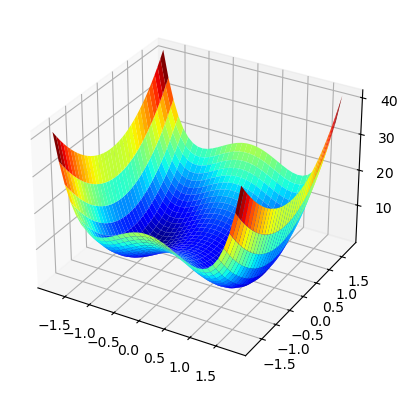

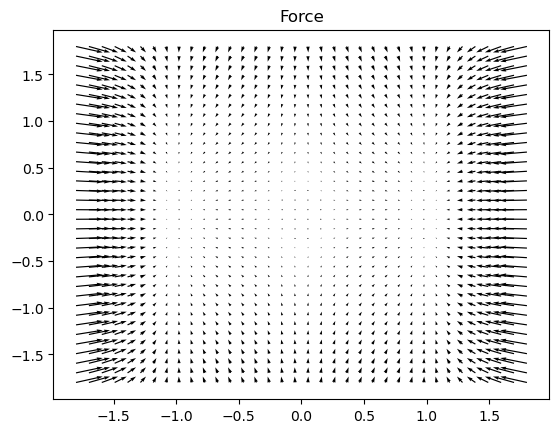

In [12]:
x = np.linspace(-1.8,1.8,36)
y = np.linspace(-1.8,1.8,36)
input=np.transpose(np.array([x,y]))

diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]) * np.eye(2,2))
a,b = 5.0, 10.0
quartic2d= fl.functions.Quartic2D(a=a,b=b)
exx = fl.functions.analytical.My_Quartic2D(a=a,b=b)

X,Y =np.meshgrid(x,y)

# Plot potential surface 
pot = exx.potential(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,pot, rstride=1, cstride=1,cmap='jet', edgecolor = 'none')

# Plot Force function
ff=quartic2d.force(input) # returns x and y components of the force : x_comp =ff[:,0] , y_comp =ff[:,1]
U,V = np.meshgrid(ff[:,0],ff[:,1])
fig, ax =plt.subplots()
ax.quiver(x,y,U,V)
ax.set_title('Force')
# plt.show()
print(quartic2d.domain)
fff=fl.functions.Quartic2DForce(exx.force, dim=2)

## 2) Simulation

In [174]:
dt = 1e-3
model_simu=fl.models.overdamped.Overdamped(force=quartic2d,diffusion=diff_function)
simulator=fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt)


In [175]:
# initialize positions 
ntraj=150
q0= np.empty(shape=[ntraj,2])
for i in range(ntraj):
    for j in range(2):
        q0[i][j]=0.0000
time_steps=10000
data_2d_unbias = simulator.run(time_steps, q0,save_every=1)  

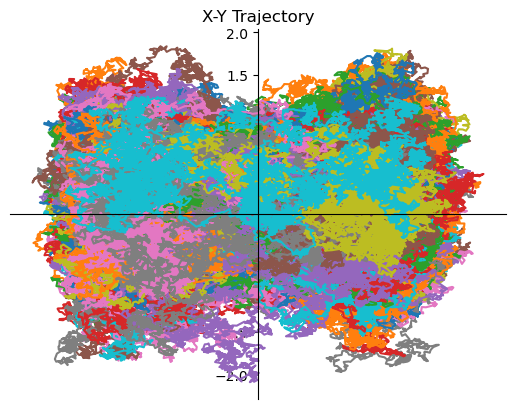

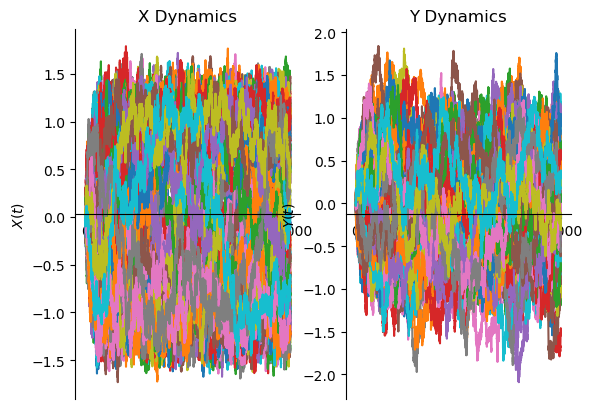

In [176]:
# Plot the resulting trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data_2d_unbias):
    axs.plot(trj["x"][:,0],trj["x"][:,1])
    axs.spines['left'].set_position('center')
    axs.spines['right'].set_color('none')
    axs.spines['bottom'].set_position('center')
    axs.spines['top'].set_color('none')
    axs.xaxis.set_ticks_position('bottom')
    axs.yaxis.set_ticks_position('left')
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

# plot x,y Trajectories in separate subplots
fig,bb =  plt.subplots(1,2)
for n, trj in enumerate(data_2d_unbias):
    bb[0].plot(trj["x"][:,0])
    bb[1].plot(trj["x"][:,1])

# Set visible  axis
    bb[0].spines['right'].set_color('none')
    bb[0].spines['bottom'].set_position('center')
    bb[0].spines['top'].set_color('none')
    bb[0].xaxis.set_ticks_position('bottom')
    bb[0].yaxis.set_ticks_position('left')
    bb[0].set_xlabel("$timestep$")
    bb[0].set_ylabel("$X(t)$")

# Set visible axis
    bb[1].spines['right'].set_color('none')
    bb[1].spines['bottom'].set_position('center')
    bb[1].spines['top'].set_color('none')
    bb[1].xaxis.set_ticks_position('bottom')
    bb[1].yaxis.set_ticks_position('left')
    bb[1].set_xlabel("$timestep$")
    bb[1].set_ylabel("$Y(t)$")

    bb[0].set_title("X Dynamics")
    bb[1].set_title("Y Dynamics")

### 2.1) 1D Simulation with same coefficients

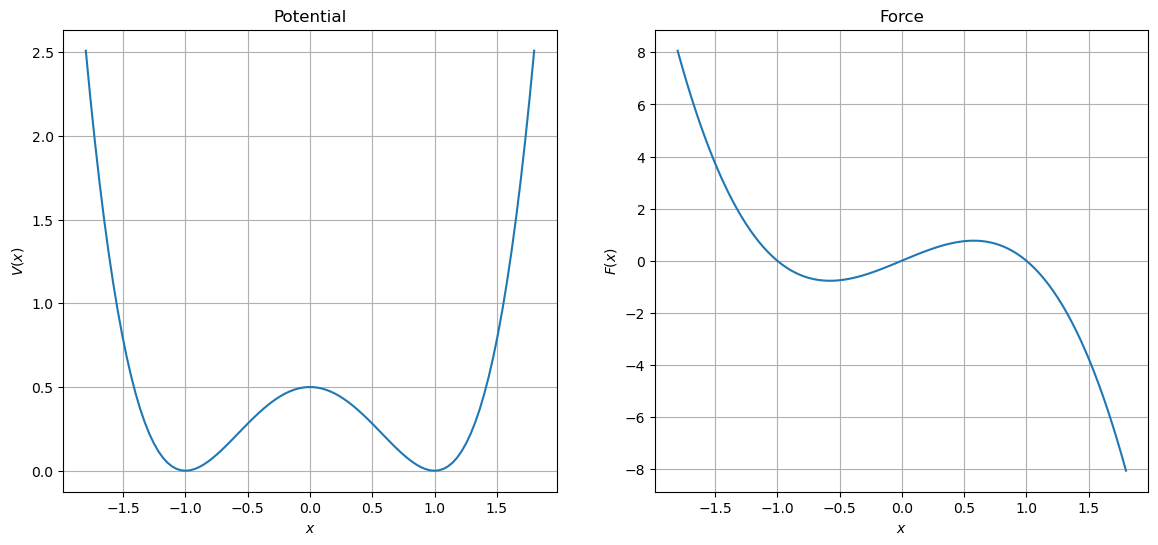

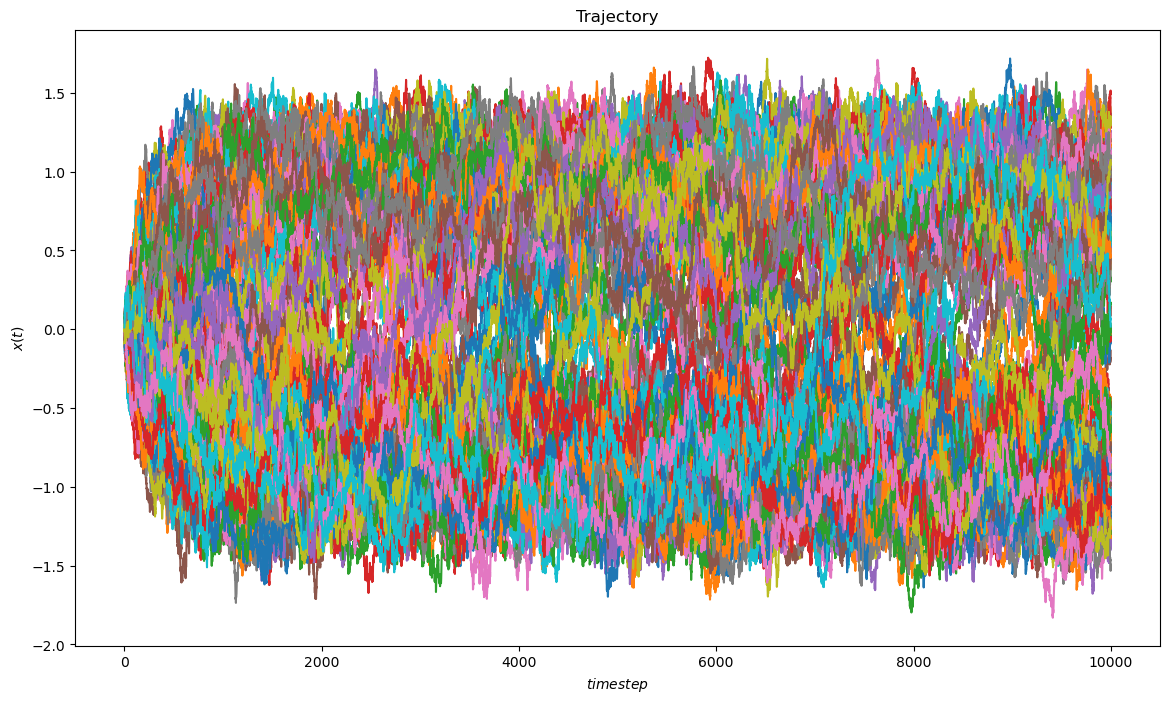

In [194]:
coeff=a*np.array([1,0,-2,0,1])
free_energy = np.polynomial.Polynomial(coeff)

force_coeff=np.array([-coeff[1],-2*coeff[2],-3*coeff[3],-4*coeff[4]])
force_function = fl.functions.Polynomial(deg=3,coefficients=force_coeff)
diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]))

# Plot of Free Energy and Force
x_values = np.linspace(-1.8, 1.8, 100)
fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].plot(x_values,free_energy(x_values))
axs[1].plot(x_values,force_function(x_values.reshape(len(x_values),1)))
axs[0].set_title("Potential")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$V(x)$")
axs[0].grid()
axs[1].set_title("Force") 
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$F(x)$") 
axs[1].grid()

# Define model to simulate and type of simulator to use
dt=1e-3
model_simu = fl.models.overdamped.Overdamped(force_function,diffusion=diff_function)
simulator = fl.simulations.Simulator(fl.simulations.EulerStepper(model_simu), dt) 

# initialize positions 
q0= np.empty(ntraj)
for i in range(len(q0)):
    q0[i]=0.000
# Calculate Trajectory, n_traj and timesteps is the same as that of the 2D simulation
data_1D_unbias = simulator.run(time_steps, q0, 1)

fig, axs = plt.subplots(figsize=(14,8))
for n, trj in enumerate(data_1D_unbias):
    axs.plot(trj["x"])
    axs.set_title("Trajectory")
    # axs[1].plot(xmax[:, n])
    axs.set_xlabel("$timestep$")
    axs.set_ylabel("$x(t)$")
    axs.grid()

## 3) Fitting 

### 3.1) Projecting onto the x Coordinate and comparison with 1D simulation


In [185]:
xdata = fl.data.trajectories.Trajectories(dt=dt) 
for n, trj in enumerate(data_2d_unbias):
    xdata.append(fl.data.trajectories.Trajectory(dt,trj["x"][:,0].reshape(len(trj["x"][:,0]),1)))
xfa = np.linspace(-1.3, 1.3, 75)
xforce = -4*a*(xfa** 3 - xfa)

#### 3.1.1) Fitting with exact model

Euler [-0.03365155  2.03314722  0.03174852 -1.99215447  0.49896585]
Elerian [-0.03365155  2.03314722  0.03174852 -1.99215447  0.49896585]
Kessler [-0.0336515   2.03314764  0.03174843 -1.99215361  0.50038753]
Drozdov [-0.03365148  2.03314767  0.03174824 -1.99215355  0.50039192]


Text(0.5, 0.98, 'Order 3 Polynomial fitting along x direction')

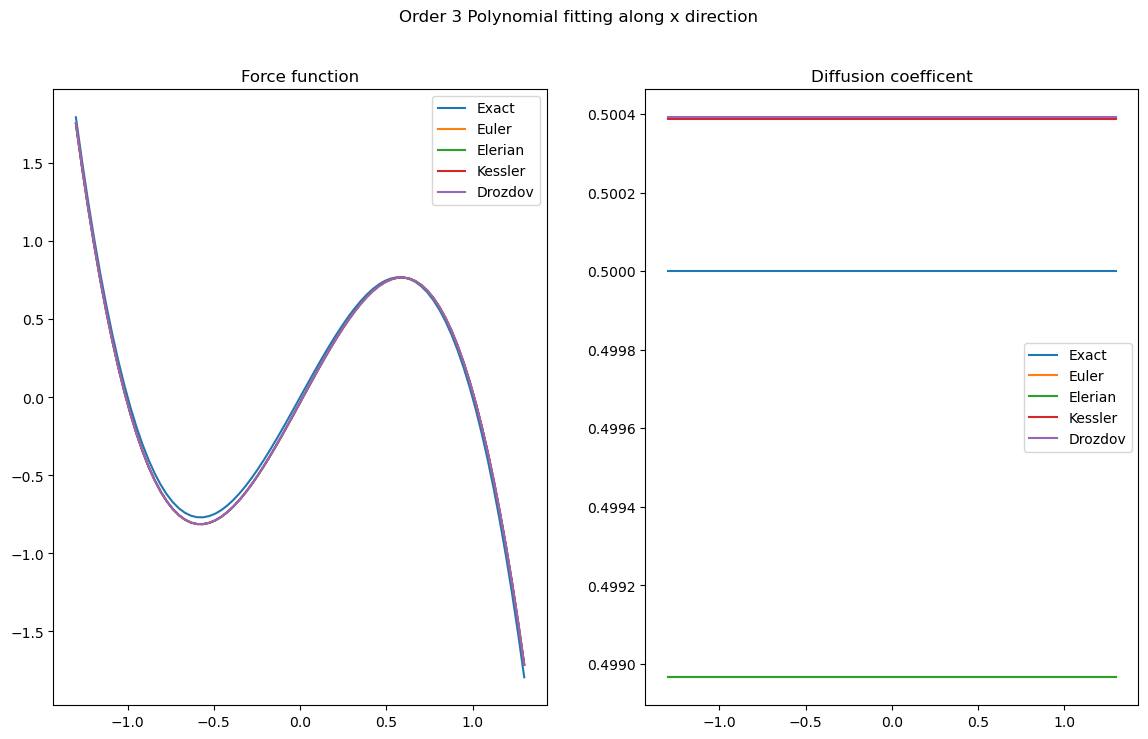

In [179]:
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
trainmodelx=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodelx)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodelx))) # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodelx))) # made by the previous estimator. So in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodelx)))


Eul_res=Eul_estimator.fit_fetch(deepcopy(xdata))
Eln_res=Eln_estimator.fit_fetch(deepcopy(xdata))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(xdata))
Drz_res=Drz_estimator.fit_fetch(deepcopy(xdata))
res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # makes a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(xfa, xforce,label='Exact')
ax[1].plot(xfa,0.5*np.ones(xfa.shape), label = 'Exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
    print(name, res.coefficients)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion coefficent')
ax[0].legend()
ax[1].legend()
fig.suptitle('Order 3 Polynomial fitting along x direction')


fitting of the 1D data 


Euler [-0.06093678  1.87395554  0.06056874 -1.91483461  0.50048655]
Elerian [-0.06093678  1.87395554  0.06056874 -1.91483461  0.50048655]
Kessler [-0.06093678  1.87395585  0.06056821 -1.91483329  0.50177036]
Drozdov [-0.06093669  1.87395581  0.06056827 -1.91483318  0.50177425]


Text(0.5, 0.98, 'Order 3 Polynomial fitting of 1D data')

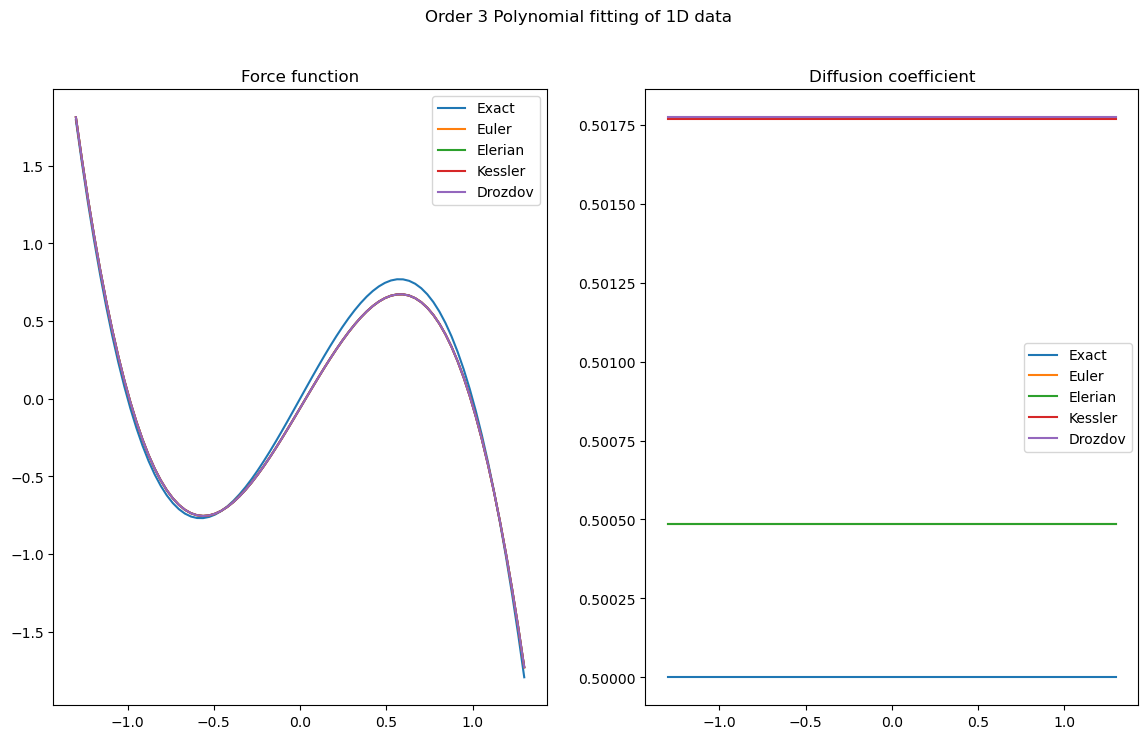

In [195]:
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
trainmodelx=fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=False)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodelx)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodelx))) # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodelx))) # made by the previous estimator. So in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodelx)))


Eul_res=Eul_estimator.fit_fetch(deepcopy(data_1D_unbias))
Eln_res=Eln_estimator.fit_fetch(deepcopy(data_1D_unbias))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(data_1D_unbias))
Drz_res=Drz_estimator.fit_fetch(deepcopy(data_1D_unbias))
res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # makes a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(xfa, xforce,label='Exact')
ax[1].plot(xfa,0.5*np.ones(xfa.shape), label = 'Exact')

for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
    print(name, res.coefficients)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion coefficient')
ax[0].legend()
ax[1].legend()
fig.suptitle('Order 3 Polynomial fitting of 1D data')

#### 3.1.2) Fitting with B-splines

Training with 4-knots B-splines

Text(0.5, 0.98, 'B-spline Fitting with 4 knots')

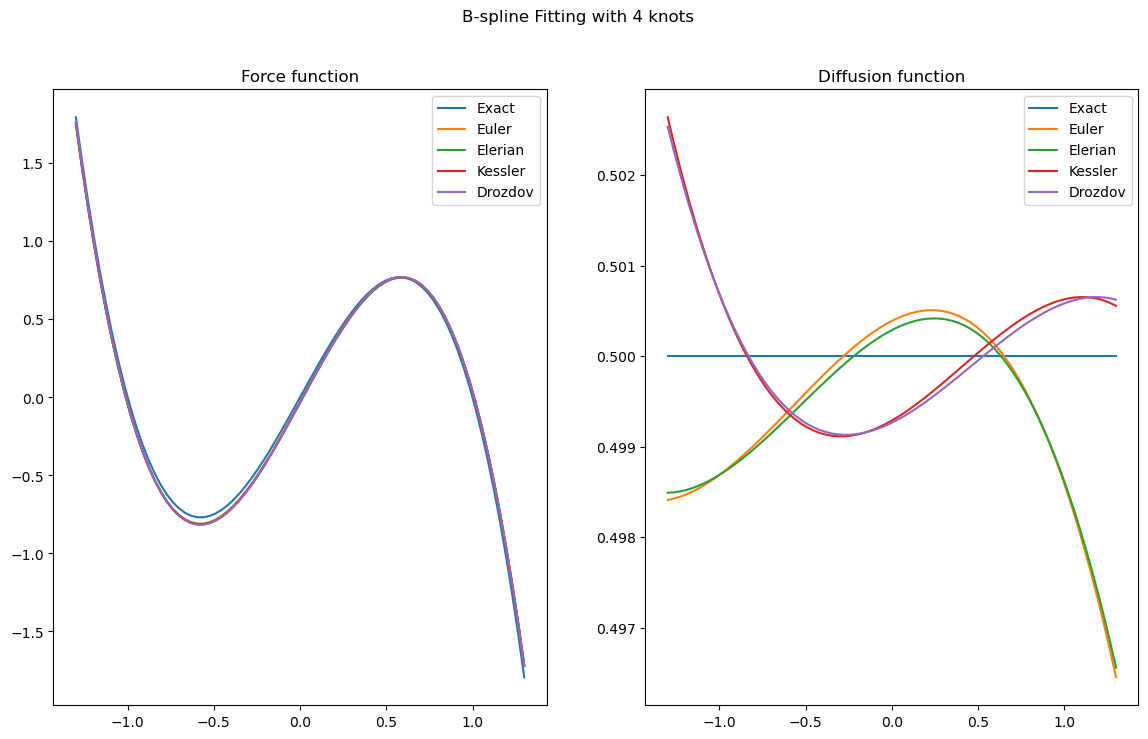

In [190]:
n_knots=4
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(xdata.stats.min,xdata.stats.max , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel))) # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previous estimator. So in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(deepcopy(xdata))
Eln_res=Eln_estimator.fit_fetch(deepcopy(xdata))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(xdata))
Drz_res=Drz_estimator.fit_fetch(deepcopy(xdata))

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(xfa, xforce,label='Exact')
ax[1].plot(xfa,0.5*np.ones(xfa.shape), label = 'Exact')

for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')



fitting of the 1D data with Bsplines

Text(0.5, 0.98, '1D data B-spline Fitting with 4 knots')

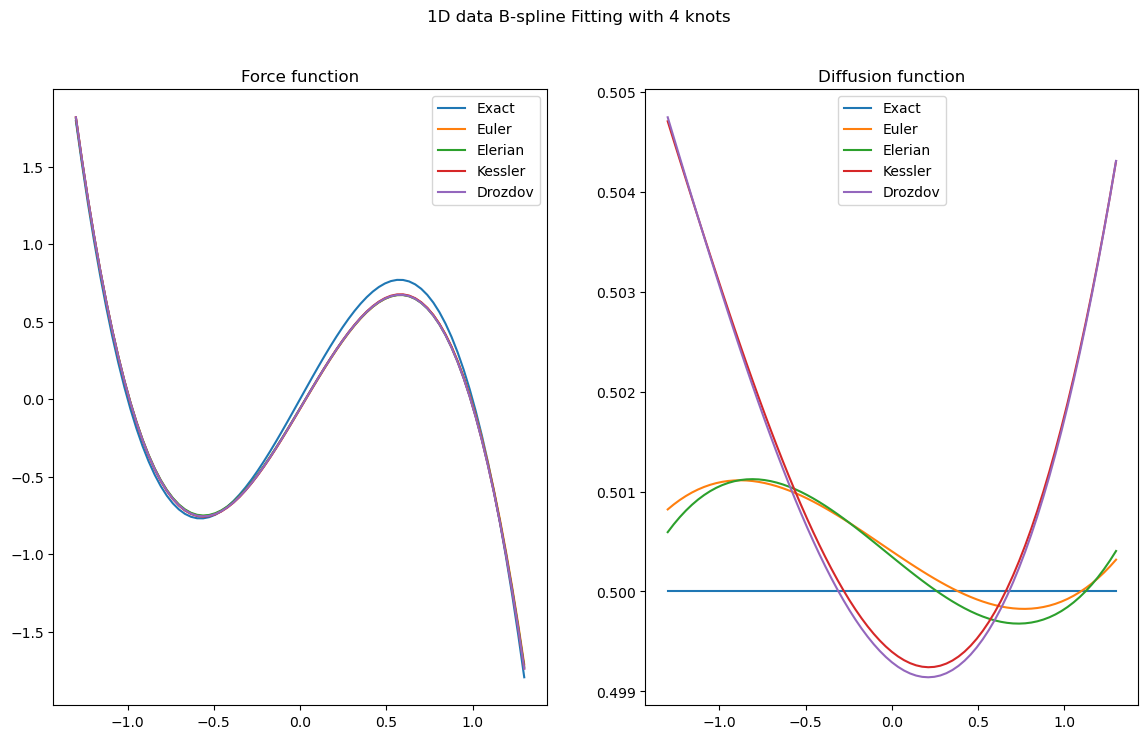

In [196]:
n_knots=4
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(data_1D_unbias.stats.min,data_1D_unbias.stats.max , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)
Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel))) # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previous estimator. So in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel)))

Eul_res=Eul_estimator.fit_fetch(deepcopy(data_1D_unbias))
Eln_res=Eln_estimator.fit_fetch(deepcopy(data_1D_unbias))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(data_1D_unbias))
Drz_res=Drz_estimator.fit_fetch(deepcopy(data_1D_unbias))

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(xfa, xforce,label='Exact')
ax[1].plot(xfa,0.5*np.ones(xfa.shape), label = 'Exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('1D data B-spline Fitting with '+str(n_knots)+ ' knots')


### 3.2) Projection onto y coordinate

In [197]:
ydata = fl.data.trajectories.Trajectories(dt=dt) 
for n, trj in enumerate(data_2d_unbias):
    ydata.append(fl.data.trajectories.Trajectory(dt,trj["x"][:,1].reshape(len(trj["x"][:,1]),1)))
yfa = np.linspace(-1.3, 1.3, 75)
yforce= -b*yfa

#### 3.2.1) Fitting with exact  Ornstein–Uhlenbeck model

Text(0.5, 0.98, 'Ornstein–Uhlenbeck Fit along y direction')

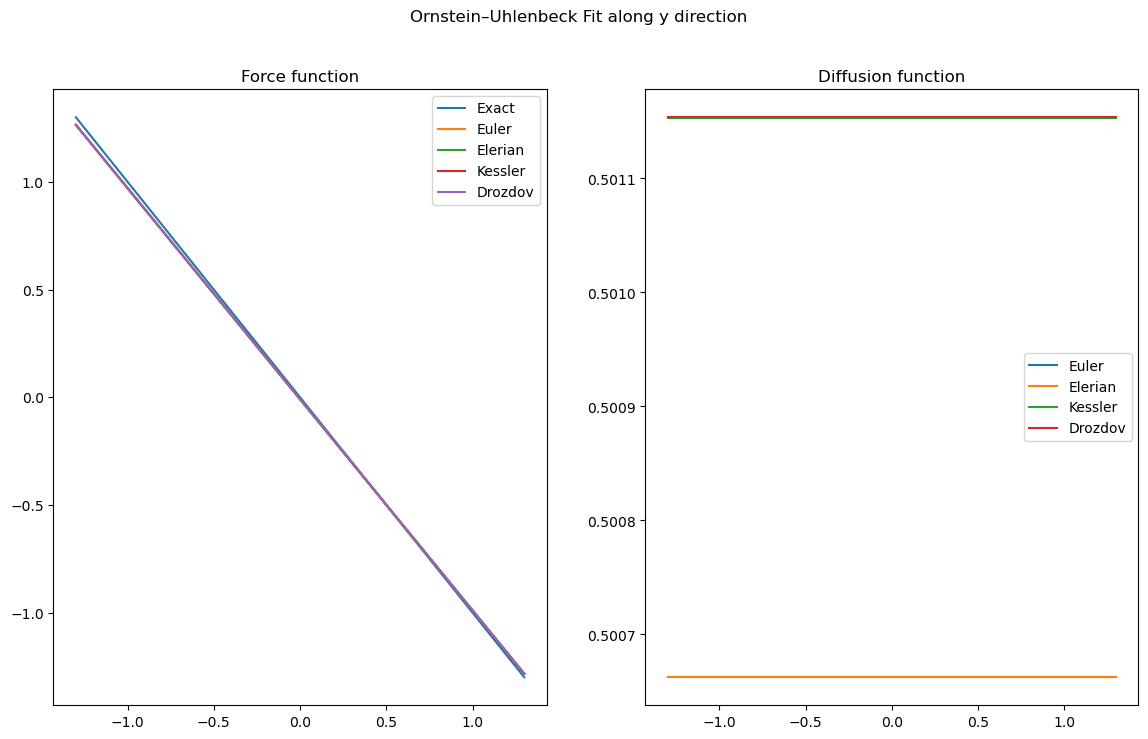

In [192]:
trainmodely=fl.models.OrnsteinUhlenbeck(has_bias=False)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodely)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodely))) # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodely))) # made by the previous estimator. So in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodely)))

Eul_res=Eul_estimator.fit_fetch(deepcopy(ydata))
Eln_res=Eln_estimator.fit_fetch(deepcopy(ydata))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(ydata))
Drz_res=Drz_estimator.fit_fetch(deepcopy(ydata))

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # makes a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(14,8))
ax[0].plot(yfa, yforce,label='Exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(yfa, res.force(yfa.reshape(-1, 1)), label=name)
    ax[1].plot(yfa, res.diffusion(yfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('Ornstein–Uhlenbeck Fit along y direction')

In [ ]:
for res in res_vec:
    print(res.coefficients)

[-0.03144491 -9.61816071  0.495372  ]
[-0.03144491 -9.61816071  0.495372  ]
[-0.03144495 -9.61815964  0.50016092]
[-0.03144491 -9.61815881  0.50018333]


### 3.3) Projecting onto $1^{st}$ and $3^{rd}$ quadrant bisectrix

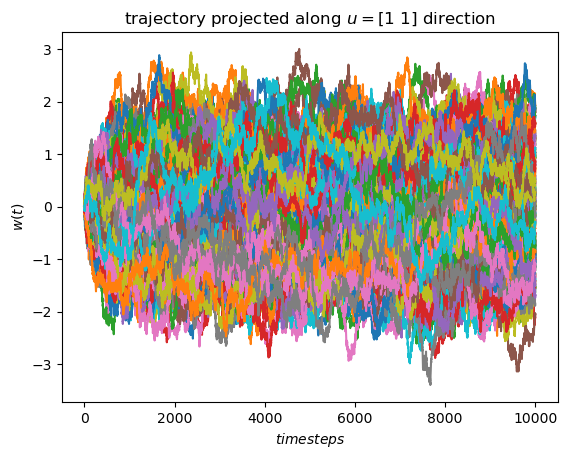

In [199]:
u = np.array([1,1])
u_norm= (1/np.linalg.norm(u,2))*u
proj_data = fl.data.trajectories.Trajectories(dt=dt) # create new Trajectory object in which to store the projected trajectory dictionaries
fig, axs =plt.subplots()
for n, trj in enumerate(data_2d_unbias):
    proj_data.append(fl.data.Trajectory(dt,(trj["x"][:,0]+trj["x"][:,1]).reshape(len(trj["x"][:,0]),1)))
    axs.plot(proj_data[n]["x"])
    axs.set_xlabel("$timesteps$")
    axs.set_ylabel("$w(t)$")
    axs.set_title("trajectory projected along $u =$"  + str(u) + " direction")
    axs.grid()

#### 3.3.1) Fitting with splines

Text(0.5, 0.98, 'Projection along $u =$[1 1] direction \n B-spline Fitting with 4 knots')

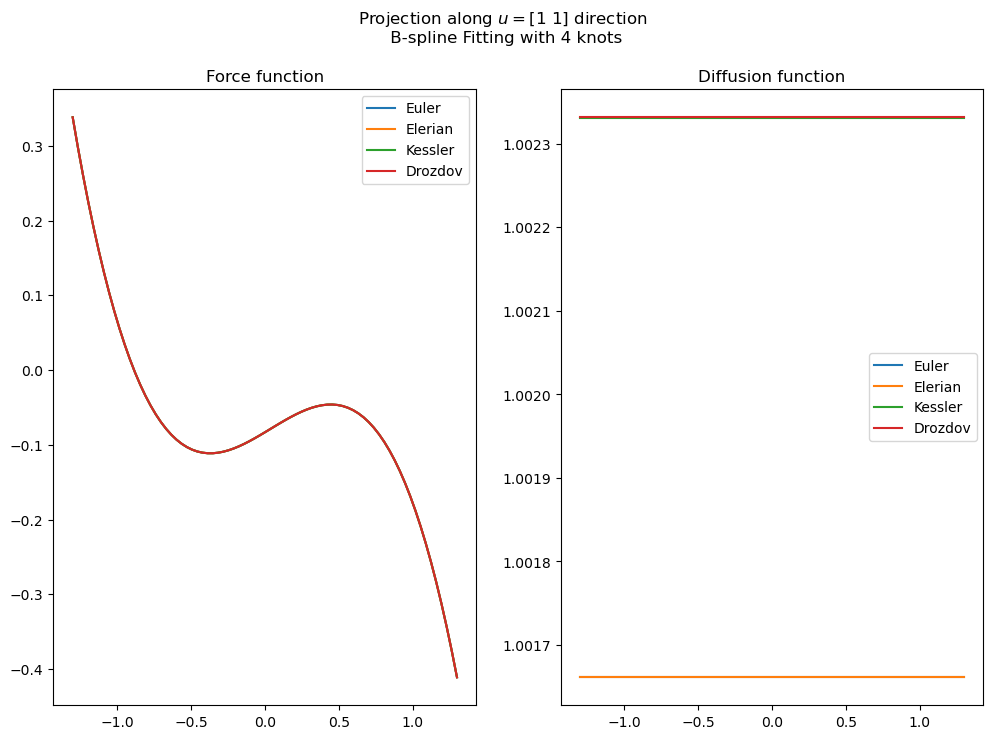

In [200]:
n_knots=4
xfa = np.linspace(-1.3, 1.3, 75)
domain = fl.MeshedDomain.create_from_range(np.linspace(proj_data.stats.min, proj_data.stats.max, n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)


Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodelx)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodelx))) # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodelx))) # made by the previous estimator. So in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodelx)))

Eul_res=Eul_estimator.fit_fetch(deepcopy(proj_data))
Eln_res=Eln_estimator.fit_fetch(deepcopy(proj_data))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(proj_data))
Drz_res=Drz_estimator.fit_fetch(deepcopy(proj_data))

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('Projection along $u =$'  + str(u) + ' direction \n B-spline Fitting with '+str(n_knots)+ ' knots')


# 2D BIASED Double Well Potential

## 1) Model 

Here we model the double well potential as a quartic function along x and a parabola along y $V(x,y)= a(x^2-1)^2 + \frac{1}{2}by^2$
and constant diffusion matrix $D= d\begin{bmatrix} 1 \ \ 0 \\\ 0 \ \ 1 \end{bmatrix} $ 


Text(0.5, 1.0, 'Force')

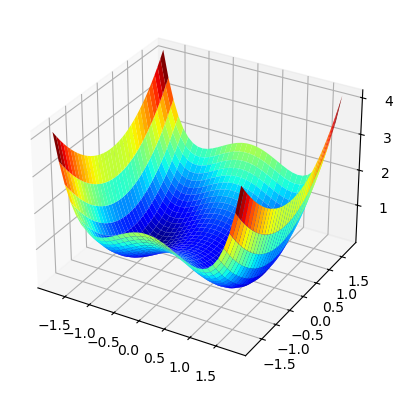

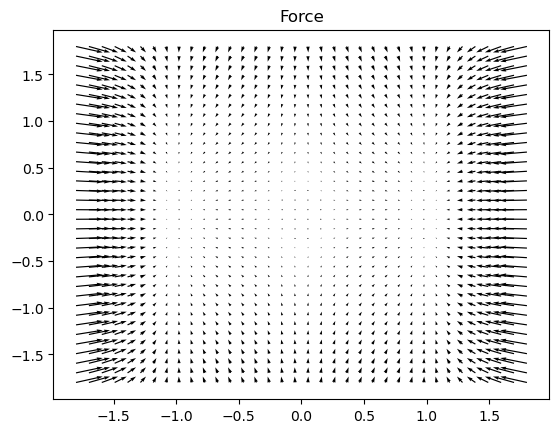

In [3]:
x = np.linspace(-1.8,1.8,36)
y = np.linspace(-1.8,1.8,36)
input=np.transpose(np.array([x,y]))

diff_function= fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.5]) * np.eye(2,2))
a,b = 0.5, 1.0
quartic2d= fl.functions.Quartic2D(a=a,b=b)
exx = fl.functions.analytical.My_Quartic2D(a=a,b=b)

X,Y =np.meshgrid(x,y)

# Plot potential surface 
pot = exx.potential(X,Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,pot, rstride=1, cstride=1,cmap='jet', edgecolor = 'none')

# Plot Force function
ff=quartic2d.force(input) # returns x and y components of the force : x_comp =ff[:,0] , y_comp =ff[:,1]
U,V = np.meshgrid(ff[:,0],ff[:,1])
fig, ax =plt.subplots()
ax.quiver(x,y,U,V)
ax.set_title('Force')

# print(quartic2d.domain)
# fff=fl.functions.Quartic2DForce(exx.force, dim=2)


On top of that we apply a linear bias along the chosen collective variable $q(x,y)= x+y$ feeding to the biased 1DColval simulator class the collective variable as a function and its gradient as an explicit array

## 2) Simulation

In [7]:
def colvar (x,y):
    return x + y
grad_colvar=np.array([1,1])
dt = 1e-3
model_simu=fl.models.overdamped.Overdamped(force=quartic2d,diffusion=diff_function)
simulator=fl.simulations.ABMD_2D_to_1DColvar_Simulator(fl.simulations.EulerStepper(model_simu), dt,colvar=colvar,k=7.0,qstop=1.5)


In [8]:
# initialize positions 
ntraj=30
q0= np.empty(shape=[ntraj,2])
for i in range(ntraj):
    for j in range(2):
        q0[i][j]=-1.2
time_steps=5000
data_2d_bias = simulator.run(time_steps, q0,save_every=1)  

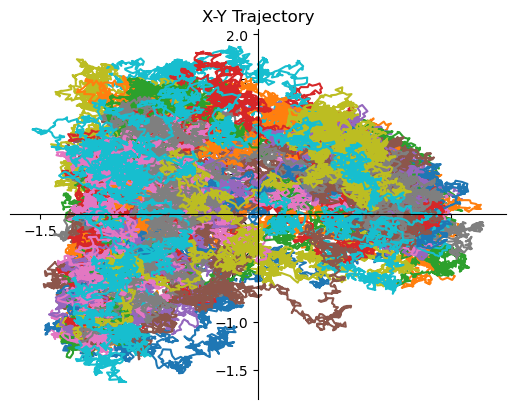

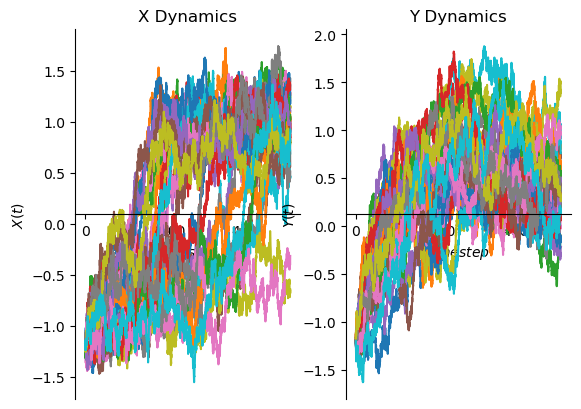

In [9]:
# Plot the resulting trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data_2d_bias):
    axs.plot(trj["x"][:,0],trj["x"][:,1])
    axs.spines['left'].set_position('center')
    axs.spines['right'].set_color('none')
    axs.spines['bottom'].set_position('center')
    axs.spines['top'].set_color('none')
    axs.xaxis.set_ticks_position('bottom')
    axs.yaxis.set_ticks_position('left')
    axs.set_xlabel("$X(t)$")
    axs.set_ylabel("$Y(t)$")
    axs.set_title("X-Y Trajectory")
    axs.grid()

"""fig, axs = plt.subplots(1,2)
for n, trj in enumerate(data_2d_bias):
    axs[0].plot(trj["x"][:,0],trj["x"][:,1])
    #axs[1].plot(xmax[:, n])
    axs[1].set_xlabel("$timestep$")
    axs[1].set_ylabel("$x(t)$")
    axs[1].grid()"""
# plot x,y Trajectories in separate subplots
fig,bb =  plt.subplots(1,2)
for n, trj in enumerate(data_2d_bias):
    bb[0].plot(trj["x"][:,0])
    bb[1].plot(trj["x"][:,1])

# Set visible  axis
    bb[0].spines['right'].set_color('none')
    bb[0].spines['bottom'].set_position('center')
    bb[0].spines['top'].set_color('none')
    bb[0].xaxis.set_ticks_position('bottom')
    bb[0].yaxis.set_ticks_position('left')
    bb[0].set_xlabel("$timestep$")
    bb[0].set_ylabel("$X(t)$")

# Set visible axis
    bb[1].spines['right'].set_color('none')
    bb[1].spines['bottom'].set_position('center')
    bb[1].spines['top'].set_color('none')
    bb[1].xaxis.set_ticks_position('bottom')
    bb[1].yaxis.set_ticks_position('left')
    bb[1].set_xlabel("$timestep$")
    bb[1].set_ylabel("$Y(t)$")

    bb[0].set_title("X Dynamics")
    bb[1].set_title("Y Dynamics")

## 3) Fitting

### 3.1) Projecting onto the x Coordinate 


In [10]:
xdata_bias = fl.data.trajectories.Trajectories(dt=dt) 
s = np.empty(shape=(len(trj["x"][:,0]),1))
for n, trj in enumerate(data_2d_bias):
    xdata_bias.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,0].reshape(len(trj["x"][:,0]),1), bias=trj["bias"][:,:1].reshape(len(trj["bias"][:,1]),1)))

xfa = np.linspace(-1.3, 1.3, 75)
xforce = -4*a*(xfa** 3 - xfa)

#### 3.1.1) Fitting with exact model

Euler [-1.08682902e-03  2.02650087e+00 -1.02474133e-02 -2.06591977e+00
  5.04970392e-01]
Elerian [-1.08682902e-03  2.02650087e+00 -1.02474133e-02 -2.06591977e+00
  5.04970392e-01]
Kessler [-1.08682902e-03  2.02650087e+00 -1.02474133e-02 -2.06591977e+00
  5.04970392e-01]
Drozdov [-1.08682902e-03  2.02650087e+00 -1.02474133e-02 -2.06591977e+00
  5.04970392e-01]


Text(0.5, 0.98, ' \n Order 3 Polynomial fitting along x direction ')

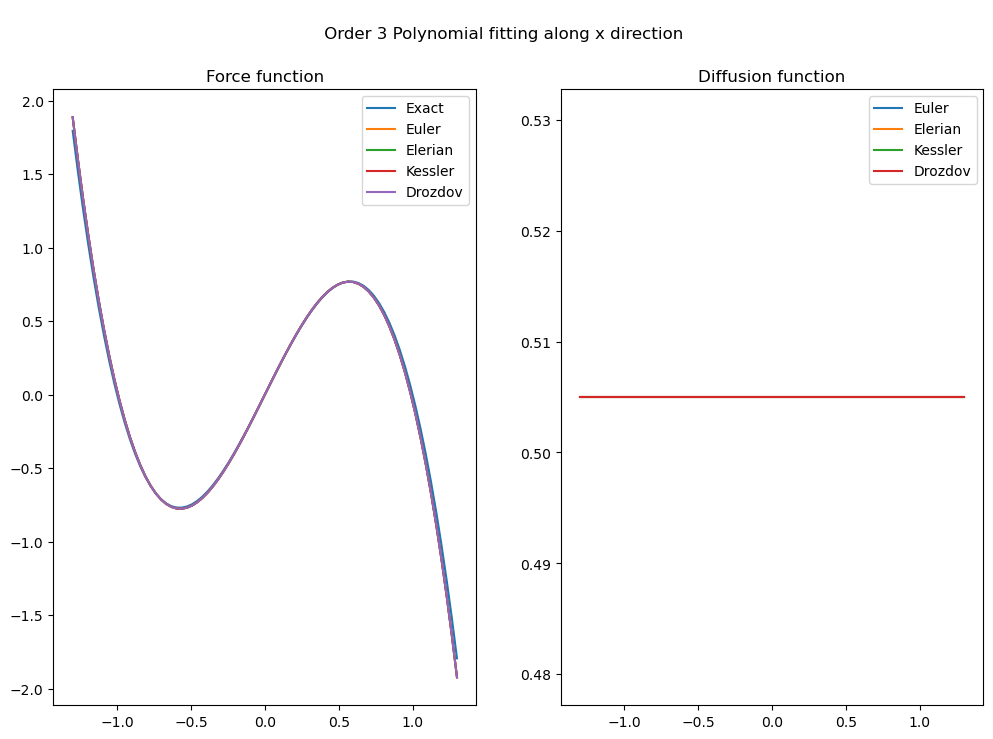

In [11]:

trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
Eul_biased_trainmodelx = fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True) # created many object trainmodelx because apparently if the model is biased 
Eln_biased_trainmodelx = fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True) # it gives recursion error in using deepcopy
Ksl_biased_trainmodelx = fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True)
Drz_biased_trainmodelx = fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity((Eul_biased_trainmodelx)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity((Eln_biased_trainmodelx))) # and when the second estimator uses the object trainmodel this will already have the modfications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity((Ksl_biased_trainmodelx))) # made by the previuos estimatorand so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity((Drz_biased_trainmodelx))) # 


Eul_res=Eul_estimator.fit_fetch(deepcopy(xdata_bias))
Eln_res=Eln_estimator.fit_fetch(deepcopy(xdata_bias))
Ksl_res=Ksl_estimator.fit_fetch(deepcopy(xdata_bias))
Drz_res=Drz_estimator.fit_fetch(deepcopy(xdata_bias))
res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))

ax[0].plot(xfa, xforce,label='Exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,):
    res.remove_bias()
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
    print(name, res.coefficients)

ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle(' \n Order 3 Polynomial fitting along x direction ')



### 3.2) Projecting along y coordinate 

In [14]:
ydata_bias = fl.data.trajectories.Trajectories(dt=dt) 

for n, trj in enumerate(data_2d_bias):
    ydata_bias.append(fl.data.trajectories.Trajectory(dt, trj["x"][:,1].reshape(len(trj["x"][:,1]),1), bias=trj["bias"][:,1].reshape(len(trj["bias"][:,1]),1)))

yfa = np.linspace(-1.3, 1.3, 75)
yforce = -b*yfa

Euler [ 0.10781832 -1.26889434  0.49581896]
Elerian [ 0.10864756 -1.27032449  0.4958675 ]
Kessler [ 0.10830226 -1.27088337  0.49649603]
Drozdov [ 0.10833826 -1.27083758  0.49649758]
KM[0.         0.         0.         0.         0.49643168]


Text(0.5, 0.98, 'Order 3 Polynomial fitting along x direction')

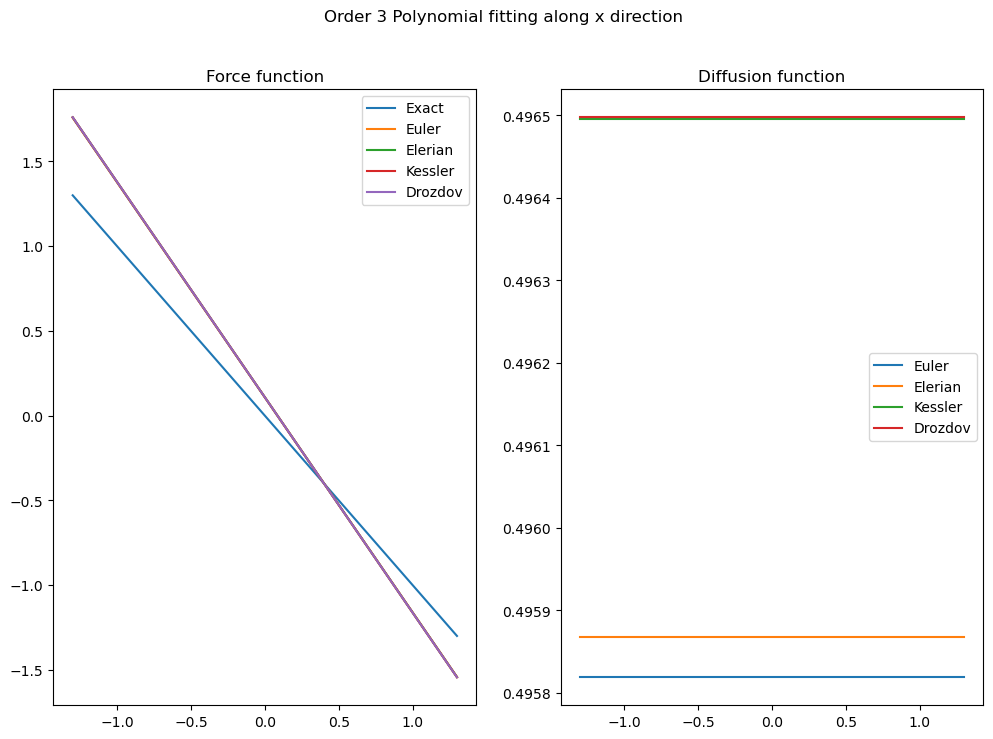

In [15]:
trainforce =fl.functions.Polynomial(deg=3,coefficients=np.asarray([1,1,1,1]))
traindiff = fl.functions.Polynomial(deg=0,coefficients=np.asarray([0.0]))
Eul_biased_trainmodely = fl.models.overdamped.OrnsteinUhlenbeck(has_bias=True)  # created many object trainmodelx because apparently
Eln_biased_trainmodely = fl.models.overdamped.OrnsteinUhlenbeck(has_bias=True)  # it gives recursion error in using deepcopy
Ksl_biased_trainmodely = fl.models.overdamped.OrnsteinUhlenbeck(has_bias=True)
Drz_biased_trainmodely = fl.models.overdamped.OrnsteinUhlenbeck(has_bias=True)
KMmodel = fl.models.Overdamped(force = trainforce,diffusion=traindiff, has_bias=True)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity((Eul_biased_trainmodely)))   # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity((Eln_biased_trainmodely))) # and when the second estimator uses the object trainmodel this will already have the modfications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity((Ksl_biased_trainmodely))) # made by the previuos estimatorand so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity((Drz_biased_trainmodely))) 

res_KM = fl.KramersMoyalEstimator(KMmodel).fit_fetch(ydata_bias)
Eul_res=Eul_estimator.fit_fetch(ydata_bias)
Eln_res=Eln_estimator.fit_fetch(ydata_bias)
Ksl_res=Ksl_estimator.fit_fetch(ydata_bias)
Drz_res=Drz_estimator.fit_fetch(ydata_bias)
res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
# axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
# axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")
ax[0].plot(xfa, yforce,label='Exact')
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,):
    res.remove_bias()
    ax[0].plot(xfa, res.force(xfa.reshape(-1, 1)), label=name)
    ax[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)), label=name)
    print(name, res.coefficients)
print('KM'+str(res_KM.coefficients))
ax[0].set_title('Force function')
ax[1].set_title('Diffusion function')
ax[0].legend()
ax[1].legend()
fig.suptitle('Order 3 Polynomial fitting along x direction')

### 3.3) Projecting along biased coordinate

In [16]:
u = np.array([1,1])
qdata = fl.data.trajectories.Trajectories(dt=dt) 

for n, trj in enumerate(data_2d_bias):
    qdata.append(fl.data.trajectories.Trajectory(dt, (trj["x"][:,0]+trj["x"][:,1]).reshape(len(trj["x"][:,0]),1), bias = (trj["bias"][:,0]+trj["bias"][:,1]).reshape(len(trj["bias"][:,0]),1)))


/home/dbersano/folie/folie/estimation/transitionDensity.py:20: RuntimeWarning: invalid value encountered in log
  ll = -0.5 * ((xt.ravel() - E) ** 2 / V) - 0.5 * np.log(np.sqrt(2 * np.pi) * V)


Model is not biased
Model is not biased
Model is not biased
Model is not biased


Text(0.5, 0.98, 'B-spline Fitting with 4 knots')

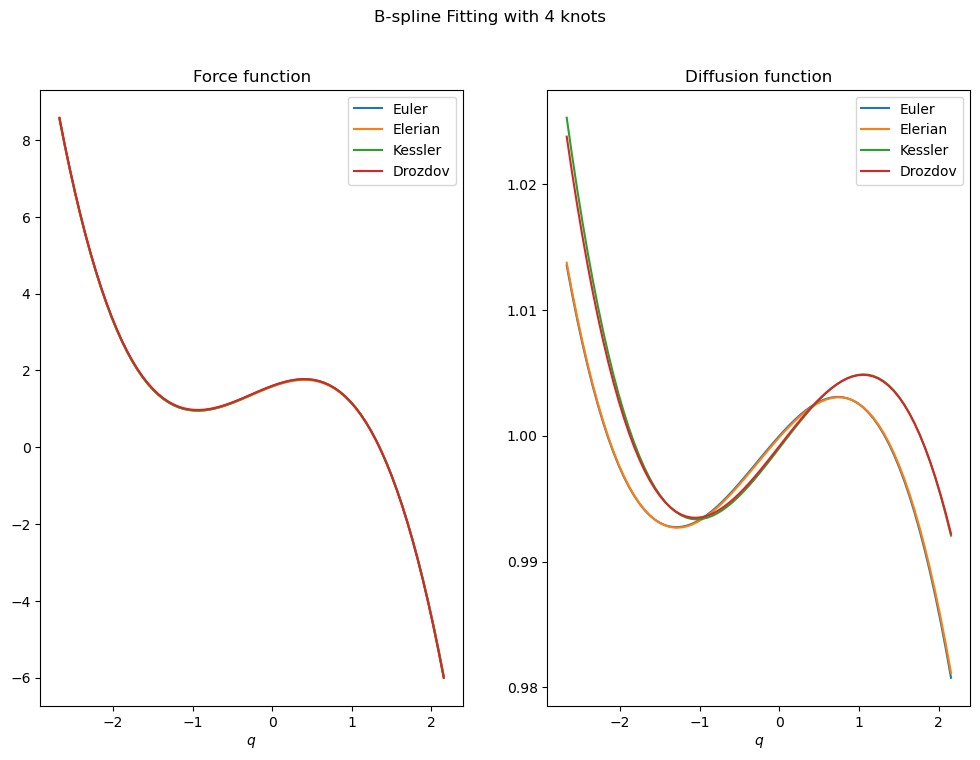

In [17]:
n_knots=4
qfa = np.linspace(qdata.stats.min , qdata.stats.max,75)

domain = fl.MeshedDomain.create_from_range(np.linspace(min(qfa) , max(qfa) , n_knots).ravel())
trainmodel = fl.models.OverdampedSplines1D(domain=domain)

Eul_estimator = fl.LikelihoodEstimator(fl.EulerDensity(deepcopy(trainmodel)))  # deepcopy is used because the estimator modifies the model when fit method is called
Eln_estimator = fl.LikelihoodEstimator(fl.ElerianDensity(deepcopy(trainmodel)))  # and when the second estimator uses the object trainmodel this will already have the modifications
Ksl_estimator = fl.LikelihoodEstimator(fl.KesslerDensity(deepcopy(trainmodel))) # made by the previuos estimator and so in the end they will return the exact same results
Drz_estimator = fl.LikelihoodEstimator(fl.DrozdovDensity(deepcopy(trainmodel))) # which is the reason why the loop checking if the values are different in the following cell exists

Eul_res=Eul_estimator.fit_fetch(qdata)
Eln_res=Eln_estimator.fit_fetch(qdata)
Ksl_res=Ksl_estimator.fit_fetch(qdata)
Drz_res=Drz_estimator.fit_fetch(qdata)

res_vec = [Eul_res,Eln_res,Ksl_res,Drz_res] # made a list of all the trained estimators 

# PLOT OF THE RESULTS 

fig,ax = plt.subplots(1,2,figsize=(12,8))
for name, res in zip(
    ["Euler", "Elerian","Kessler", "Drozdov"], res_vec,
):
    res.remove_bias()
    ax[0].plot(qfa, res.force(qfa.reshape(-1, 1)), label=name)
    ax[1].plot(qfa, res.diffusion(qfa.reshape(-1, 1)), label=name)
ax[0].set_title('Force function')
ax[0].set_xlabel("$q$")
ax[1].set_title('Diffusion function')
ax[1].set_xlabel("$q$")
ax[0].legend()
ax[1].legend()
fig.suptitle('B-spline Fitting with '+str(n_knots)+ ' knots')
